In [1]:
import os, glob
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd

## CLIP Label text

In [18]:
from transformers import AutoTokenizer, CLIPTextModel#, CLIPTextModelWithProjection

# model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")



/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# resc
# inputs = tokenizer([
#     "an optical coherence tomography b-scan of healthy retina",
#     "an optical coherence tomography b-scan with subretinal fluid", 
#     "an optical coherence tomography b-scan with retinal pigment epithelial detachment"], padding=True, return_tensors="pt")
# duke
# inputs = tokenizer([
#     "an optical coherence tomography b-scan of healthy retina",
#     "an optical coherence tomography b-scan with severe diabetic macular edema",], padding=True, return_tensors="pt")
# ours
inputs = tokenizer([
    "an optical coherence tomography b-scan of healthy retina",
    "an optical coherence tomography b-scan with sub-retinal fluid",
    "an optical coherence tomography b-scan with intra-retinal fluid",
    "an optical coherence tomography b-scan with disruption in the ellipsoid zone",
    "an optical coherence tomography b-scan with hyperreflective dots",
], padding=True, return_tensors="pt")
    
outputs = model(**inputs)
text_embeds = outputs.pooler_output

In [20]:
import pickle
with open("text_features/ours/clip_label_large.pkl", "wb") as f:
    pickle.dump(text_embeds, f)
text_embeds

tensor([[ 1.1573, -0.0434,  0.5572,  ..., -1.8477,  0.1376,  0.6069],
        [ 0.9232, -0.1722,  1.5495,  ..., -2.2204,  0.1450,  0.0669],
        [ 0.6909, -0.1055,  1.4018,  ..., -2.1419,  0.1351,  0.1722],
        [ 0.3494,  0.0954,  2.6075,  ..., -1.2693,  0.4795, -1.0461],
        [ 1.2496, -0.3680,  2.2028,  ..., -1.3891,  0.2139, -0.4516]],
       grad_fn=<IndexBackward0>)

In [21]:
text_embeds.shape

torch.Size([5, 768])

In [ ]:
import pickle
with open("text_features/clip_f.pkl", "wb") as f:
    pickle.dump(text_embeds, f)
text_embeds

tensor([[ 1.4436, -0.4988,  1.4294,  ...,  1.3873,  1.3876, -0.8252],
        [ 1.0922, -0.1201,  1.7429,  ...,  1.3311,  1.0952, -1.2815],
        [ 1.4622,  0.0177,  1.1340,  ...,  0.9983,  1.0603, -0.4637]],
       grad_fn=<IndexBackward0>)

In [ ]:
import pickle
with open("text_features/clip-vit-large-patch14-f.pkl", "wb") as f:
    pickle.dump(text_embeds, f)
text_embeds.shape

torch.Size([3, 768])

## Caption generation

### vit-gpt2, blip, miniLM

In [2]:

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from transformers import BlipProcessor, BlipForConditionalGeneration

import torch
from PIL import Image

vit_caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_caption_feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

blip_caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

# from transformers import AutoProcessor, BlipForQuestionAnswering
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
# processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

from transformers import AutoTokenizer, CLIPTextModel#, CLIPTextModelWithProjection

clip_base_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
clip_base_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_large_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
clip_large_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")



/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/xiaolhu/.local/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [30]:
from sentence_transformers import SentenceTransformer, util

encoder_model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
min_length = 5
max_length = 20
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "min_length": min_length}
list_of_image_paths = glob.glob("../datasets/2015_BOE_Chiu/segment_annotation/images/*")
images = []
for image_path in list_of_image_paths:
  i_image = Image.open(image_path)
  if i_image.mode != "RGB":
    i_image = i_image.convert(mode="RGB")

  images.append({"path": image_path, "img": i_image})

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
vit_caption_model.to(device)

print("done")
pixel_values = vit_caption_feature_extractor(images=[x["img"] for x in images], return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

# every 8 is one batch
result_list = []
step = 400
# jump every step of the index change
for i in range(0, len(images), step):
    print(i)
    pixel_val_batch = pixel_values[i: i + step]
    images_path_batch = images[i: i + step]
    output_ids = model.generate(pixel_val_batch, **gen_kwargs)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    clip_inputs = clip_base_tokenizer(preds, padding=True, return_tensors="pt")
    clip_outputs = clip_base_model(**clip_inputs)
    text_embeds = clip_outputs.pooler_output
    for _idx in range(len(pixel_val_batch)):
        result_list.append({
            "path": images_path_batch[_idx]["path"], 
            "pred": preds[_idx].strip(),
            "clip_base_embed": text_embeds[_idx]
        })

In [5]:
with open("text_features/resc/blip_train_caption_f.pkl", "rb") as f: # blip_train_caption_f
    blip_train_result_list = pickle.load(f)
with open("text_features/resc/blip_valid_caption_f.pkl", "rb") as f:
    blip_val_result_list = pickle.load(f)

with open("text_features/resc/train_caption_f.pkl", "rb") as f: # blip_train_caption_f
    vit_train_result_list = pickle.load(f)
with open("text_features/resc/valid_caption_f.pkl", "rb") as f:
    vit_val_result_list = pickle.load(f) 

In [8]:
len(blip_train_result_list), len(vit_train_result_list)

(8960, 8960)

In [63]:
def get_clip_large_and_miniLM_embeds(preds):
    clip_inputs = clip_large_tokenizer(preds, padding=True, return_tensors="pt")
    clip_outputs = clip_large_model(**clip_inputs)
    clip_large_embeds = clip_outputs.pooler_output

    minilm_embeds = encoder_model.encode(preds, convert_to_tensor=True)
    return clip_large_embeds[0], minilm_embeds.cpu()

comb_val_result_list  = []
for item in tqdm(blip_val_result_list):
    found_vit_item = [x for x in vit_val_result_list if x["path"] == item["path"]]
    assert len(found_vit_item) == 1
    found_vit_item = found_vit_item[0]
    blip_pred = item["pred"]
    blip_norm_pred = blip_pred.replace("a black and white photo of", "").strip()
    vit_pred = found_vit_item["pred"]

    blip_clip_large_embeds, blip_minilm_embeds = get_clip_large_and_miniLM_embeds(blip_pred)
    blip_norm_clip_large_embeds, blip_norm_minilm_embeds = get_clip_large_and_miniLM_embeds(blip_norm_pred)
    vit_clip_large_embeds, vit_minilm_embeds = get_clip_large_and_miniLM_embeds(vit_pred)

    comb_val_result_list.append({
        "path": item["path"].replace("/scr2/xhu/jiaqi/wsss", ".."),
        "blip": {
            "pred": blip_pred,
            "norm_pred": blip_norm_pred,
            "clip_base_embed": item["clip_base_embed"],
            "norm_clip_base_embed": item["norm_clip_base_embed"],
            "clip_large_embed": blip_clip_large_embeds,
            "norm_clip_large_embed": blip_norm_clip_large_embeds,
            "minilm_embed": blip_minilm_embeds,
        },
        "vit": {
            "pred": vit_pred,
            "clip_base_embed": found_vit_item["clip_base_embed"],
            "clip_large_embed": vit_clip_large_embeds,
            "minilm_embed": vit_minilm_embeds,
        },
    })

100%|██████████| 1920/1920 [08:16<00:00,  3.87it/s]


In [65]:
len(comb_val_result_list), len(comb_train_result_list)

(1920, 8960)

In [62]:
comb_train_result_list[1]["blip"]["minilm_embed"].shape

torch.Size([384])

In [64]:
with open("text_features/resc/valid_caption_f.pkl", "wb") as f:
    pickle.dump(comb_val_result_list, f)

In [29]:
len(set([x["path"] for x in comb_train_result_list]))

1920

### duke

In [3]:
with open("text_features/resc/train_caption_f.pkl", "rb") as f: # blip_train_caption_f
    train_result_list = pickle.load(f)
with open("text_features/resc/valid_caption_f.pkl", "rb") as f:
    val_result_list = pickle.load(f)

In [7]:
with open("text_features/duke/train_caption_f.pkl", "rb") as f: # blip_train_caption_f
    duke_train_result_list = pickle.load(f)

In [4]:
resc_result_list = train_result_list + val_result_list

In [5]:
train_set = pd.read_csv("../datasets/2015_BOE_Chiu/train.csv", index_col=0)
val_set = pd.read_csv("../datasets/2015_BOE_Chiu/valid.csv", index_col=0)

In [8]:
val_set.shape, train_set.shape, len(duke_train_result_list)

((178, 2), (15235, 2), 11941)

In [10]:
for path in train_set[train_set["path"].str.contains("RESC")]["path"].tolist():
    found = [x for x in resc_result_list if x["path"] == "../" + path][0]

    duke_train_result_list.append({
        "path": "../" + path,
        "blip": {
            "pred": found["blip"]["pred"],
            "norm_pred": found["blip"]["norm_pred"],
            "norm_clip_base_embed": found["blip"]["norm_clip_base_embed"],
        },
    })

In [11]:
len(duke_train_result_list)

15235

In [44]:
train_set[train_set["path"].str.contains("RESC")].shape

(3294, 2)

In [23]:
train_set.shape, len(resc_result_list)

((15235, 2), 10880)

In [35]:
resc_result_list[0]["blip"].keys()

dict_keys(['pred', 'norm_pred', 'clip_base_embed', 'norm_clip_base_embed', 'clip_large_embed', 'norm_clip_large_embed', 'minilm_embed'])

In [48]:
# blip
# raw_image = Image.open("/scr2/xhu/jiaqi/wsss/datasets/RESC/train/original_images/sn3204_97.bmp").convert('RGB')
# conditional image captioning
text = "a black and white photo of"
# text = "what is the location of main object in the photo?"
# inputs = blip_caption_processor(raw_image, text, return_tensors="pt").to("cuda:2")
# out = model.generate(**inputs)
# print(blip_caption_processor.decode(out[0], skip_special_tokens=True))
# list_of_image_paths = glob.glob("/scr2/xhu/jiaqi/wsss/datasets/RESC/valid/original_images/*")

list_of_image_paths = val_set["path"].tolist()
result_list = []
for image_path in tqdm(list_of_image_paths):
  image_path = "../"+image_path
  found_resc_res = [x for x in resc_result_list if x["path"] == image_path]
  assert len(found_resc_res) <= 1
  if len(found_resc_res) == 1:
    continue
  i_image = Image.open(image_path)
  if i_image.mode != "RGB":
    i_image = i_image.convert(mode="RGB")
  inputs = blip_caption_processor(i_image, text, return_tensors="pt").to("cuda")
  out = blip_caption_model.generate(**inputs)
  pred = blip_caption_processor.decode(out[0], skip_special_tokens=True)
  norm_pred = pred.replace("a black and white photo of", "").strip()

  clip_inputs = clip_base_tokenizer(norm_pred, padding=True, return_tensors="pt")
  clip_outputs = clip_base_model(**clip_inputs)
  text_embeds = clip_outputs.pooler_output

  result_list.append({
      "path": image_path, 
      "blip": {
        "pred": pred.strip(),
        "norm_pred": norm_pred,
        "norm_clip_base_embed": text_embeds[0]
      }
  })

  0%|          | 0/178 [00:00<?, ?it/s]/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 178/178 [00:32<00:00,  5.55it/s]


In [12]:
with open("text_features/duke/train_caption_f.pkl", "wb") as f:
    pickle.dump(duke_train_result_list, f)

In [39]:
text_embeds.shape, image_path, len(result_list), len(list_of_image_paths) - len(result_list)

(torch.Size([1, 512]),
 '../datasets/RESC/valid/original_images/sn9291_77.bmp',
 11941,
 3294)

In [31]:
pred, norm_pred

('a black and white photo of a couch with a pillow', 'a couch with a pillow')

### ours

In [3]:
train_set = glob.glob("../datasets/our_dataset/original/train/*")
val_set = glob.glob("../datasets/our_dataset/original/test/*")

In [5]:
len(train_set), len(val_set), train_set[0]

(8006, 342, '../datasets/our_dataset/original/train/NORMAL-2026176-13.jpeg')

In [16]:
# blip
# raw_image = Image.open("/scr2/xhu/jiaqi/wsss/datasets/RESC/train/original_images/sn3204_97.bmp").convert('RGB')
# conditional image captioning
text = "a black and white photo of"
# text = "what is the location of main object in the photo?"
# inputs = blip_caption_processor(raw_image, text, return_tensors="pt").to("cuda:2")
# out = model.generate(**inputs)
# print(blip_caption_processor.decode(out[0], skip_special_tokens=True))
# list_of_image_paths = glob.glob("/scr2/xhu/jiaqi/wsss/datasets/RESC/valid/original_images/*")

result_list = []
for image_path in tqdm(val_set):
  i_image = Image.open(image_path)
  if i_image.mode != "RGB":
    i_image = i_image.convert(mode="RGB")
  inputs = blip_caption_processor(i_image, text, return_tensors="pt").to("cuda")
  out = blip_caption_model.generate(**inputs)
  pred = blip_caption_processor.decode(out[0], skip_special_tokens=True)
  norm_pred = pred.replace("a black and white photo of", "").strip()

  clip_inputs = clip_base_tokenizer(norm_pred, padding=True, return_tensors="pt")
  clip_outputs = clip_base_model(**clip_inputs)
  text_embeds = clip_outputs.pooler_output

  result_list.append({
      "path": image_path, 
      "blip": {
        "pred": pred.strip(),
        "norm_pred": norm_pred,
        "norm_clip_base_embed": text_embeds[0]
      }
  })

  0%|          | 0/342 [00:00<?, ?it/s]/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 342/342 [00:52<00:00,  6.50it/s]


In [19]:
result_list[5]

{'path': '../datasets/our_dataset/original/test/NORMAL-1998191-1.jpeg',
 'blip': {'pred': 'a black and white photo of a radiograph of a person',
  'norm_pred': 'a radiograph of a person',
  'norm_clip_base_embed': tensor([ 5.2688e-01, -1.4781e+00,  3.8496e-01,  8.0444e+00, -2.7311e+00,
           8.7867e-01,  3.7502e-01,  6.4257e-01, -8.3977e-01, -6.8037e-01,
          -5.4650e-01, -1.4266e+00, -6.2735e-01, -1.3048e+00,  1.9976e+00,
          -3.1540e-01, -1.4366e+00,  3.5155e-01, -7.3058e-01, -7.0598e-01,
           7.4035e-01,  8.5787e-01,  1.4796e-01,  7.9233e-01,  6.5253e-01,
          -7.8207e-01,  1.8019e+00,  9.5553e-01,  6.7702e-01,  1.2842e+00,
           1.4423e+00,  2.4701e-01,  1.3002e+00, -1.4329e+00, -7.9402e-01,
          -9.5885e-01,  1.4844e+00, -1.5763e-01, -4.3676e-01,  2.0216e-01,
          -9.1752e-02, -9.2018e-01, -5.6804e-01,  2.1365e+00, -2.4091e-02,
           1.0222e+00,  1.1373e+00, -1.4281e-01,  1.0136e-01, -8.0653e-01,
          -4.9494e-01, -1.6436e+00,  2

In [17]:
with open("text_features/ours/valid_caption_f.pkl", "wb") as f:
    pickle.dump(result_list, f)

## Analysis

In [5]:
train_result_list[100]["blip"].keys()

dict_keys(['pred', 'norm_pred', 'clip_base_embed', 'norm_clip_base_embed', 'clip_large_embed', 'norm_clip_large_embed', 'minilm_embed'])

In [6]:
blip_train_result_list[0].keys()

dict_keys(['path', 'pred', 'clip_base_embed', 'norm_clip_base_embed'])

In [21]:
result_list = train_result_list + val_result_list

In [22]:
result_list[0]

{'path': '../datasets/RESC/train/original_images/sn3204_2.bmp',
 'blip': {'pred': 'a black and white photo of a mountain with a body of water',
  'norm_pred': 'a mountain with a body of water',
  'clip_base_embed': tensor([-3.6321e-02, -2.0522e+00, -1.1060e-01,  5.8743e+00, -2.3638e+00,
          -6.1911e-01, -4.7061e-01,  4.4528e-01, -3.3929e-01, -9.8276e-01,
          -9.9224e-01, -1.0258e-01, -2.9632e-01,  2.7119e-01,  1.3862e+00,
           5.8320e-01, -2.4795e-01, -4.1663e-01,  2.1176e-01,  2.8835e-01,
           1.5947e-01,  7.0161e-01,  1.4291e+00,  1.5631e+00,  6.4852e-01,
          -1.2239e+00,  7.5741e-01,  5.9666e-01,  4.9246e-01,  6.8315e-01,
           1.4931e+00,  6.8973e-01,  1.3888e+00,  1.8010e-01, -3.1096e-01,
           7.1426e-01, -1.4684e-02,  4.1395e-01, -9.6396e-01,  1.9421e+00,
           1.1208e+00, -3.7038e-01, -2.7113e+00,  3.7599e+00,  7.5704e-02,
           7.4305e-01,  3.5394e-01,  3.2137e-01, -1.0073e-01, -9.9669e-01,
          -3.0339e-01, -8.8575e-02,  

In [23]:
import numpy as np
label_list = np.load("../datasets/RESC/resc_cls_labels.npy", allow_pickle=True).item()

In [24]:
len(label_list), len(result_list)

(10880, 10880)

In [25]:
all_healthy_img = []
all_srf_img = []
all_irf_img = []
for x in label_list:
    if label_list[x][0] == 0 and label_list[x][1]==0:
        all_healthy_img.append(x)
    elif label_list[x][0] == 1 and label_list[x][1]==0:
        all_srf_img.append(x)
    elif label_list[x][1] == 1 and label_list[x][0]==0:
        all_irf_img.append(x)

all_healthy_img = [x+".bmp" for x in all_healthy_img]
all_srf_img = [x+".bmp" for x in all_srf_img]
all_irf_img = [x+".bmp" for x in all_irf_img]
len(all_healthy_img), len(all_srf_img), len(all_irf_img)

(7399, 3038, 187)

In [32]:
all_healthy_description = []
all_srf_description = []
all_irf_description = []
for x in result_list:
    if x["path"].split("/")[-1] in all_healthy_img:
        all_healthy_description.append({
            "blip_norm": x["blip"]["norm_pred"],
            "vit_pred": x["vit"]["pred"],
        })
    elif x["path"].split("/")[-1] in all_srf_img:
        all_srf_description.append({
            "blip_norm": x["blip"]["norm_pred"],
            "vit_pred": x["vit"]["pred"],
        
        })
    elif x["path"].split("/")[-1] in all_irf_img:
        all_irf_description.append({
            "blip_norm": x["blip"]["norm_pred"],
            "vit_pred": x["vit"]["pred"],
        })

len(all_healthy_description), len(all_srf_description), len(all_irf_description)

all_blip_healthy_text = [x["blip_norm"] for x in all_healthy_description]
all_vit_healthy_text = [x["vit_pred"] for x in all_healthy_description]
all_blip_srf_text = [x["blip_norm"] for x in all_srf_description]
all_vit_srf_text = [x["vit_pred"] for x in all_srf_description]
all_blip_irf_text = [x["blip_norm"] for x in all_irf_description]
all_vit_irf_text = [x["vit_pred"] for x in all_irf_description]


In [35]:
len(set(all_blip_healthy_text)) / len(all_healthy_description), len(set(all_blip_srf_text)) / len(all_srf_description), len(set(all_blip_irf_text)) / len(all_irf_description)

(0.09649952696310313, 0.16754443712969058, 0.34759358288770054)

In [36]:
len(set(all_vit_healthy_text)) / len(all_healthy_description), len(set(all_vit_srf_text)) / len(all_srf_description), len(set(all_vit_irf_text)) / len(all_irf_description)

(0.1402892282740911, 0.21757735352205398, 0.47593582887700536)

(-0.5, 799.5, 499.5, -0.5)

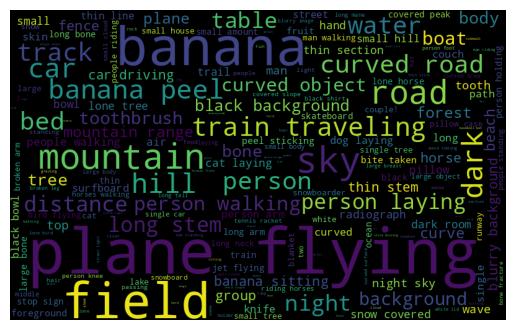

In [37]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(width = 800, height = 500).generate(" ".join(all_blip_healthy_text))
plt.imshow(wc)
plt.axis("off")


(-0.5, 799.5, 499.5, -0.5)

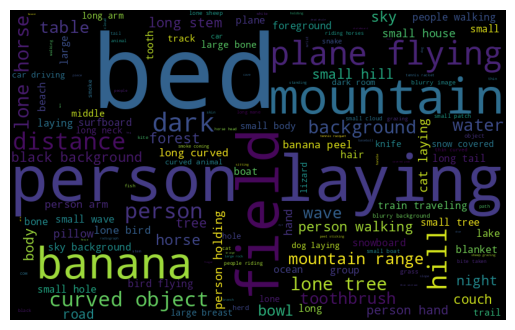

In [43]:
wc = WordCloud(width = 800, height = 500).generate(" ".join(all_blip_srf_text))
plt.imshow(wc)
plt.axis("off")

(-0.5, 799.5, 499.5, -0.5)

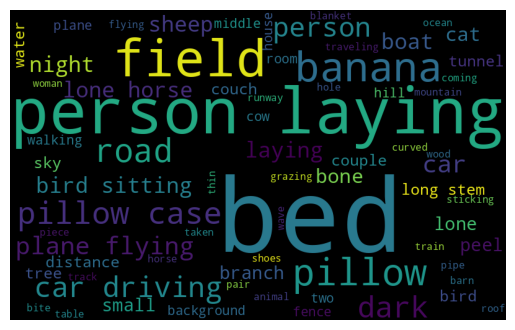

In [44]:
wc = WordCloud(width = 800, height = 500).generate(" ".join(all_blip_irf_text))
plt.imshow(wc)
plt.axis("off")

In [46]:
words_coll_healthy = [x for x in " ".join(all_blip_healthy_text).split(" ") if x not in wc.stopwords]
# draw top 10 histogram
from collections import Counter
mc = Counter(words_coll_healthy).most_common(10)

<BarContainer object of 10 artists>

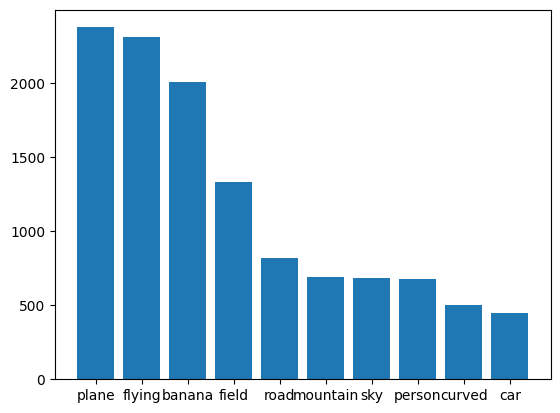

In [47]:
plt.bar(*zip(*mc))

<BarContainer object of 10 artists>

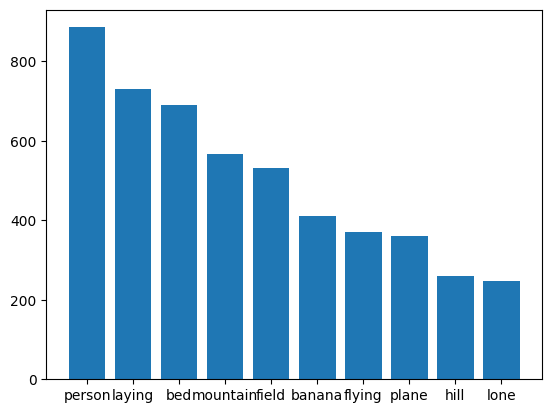

In [48]:
words_coll_srf = [x for x in " ".join(all_blip_srf_text).split(" ") if x not in wc.stopwords]
mc = Counter(words_coll_srf).most_common(10)
plt.bar(*zip(*mc))

<BarContainer object of 10 artists>

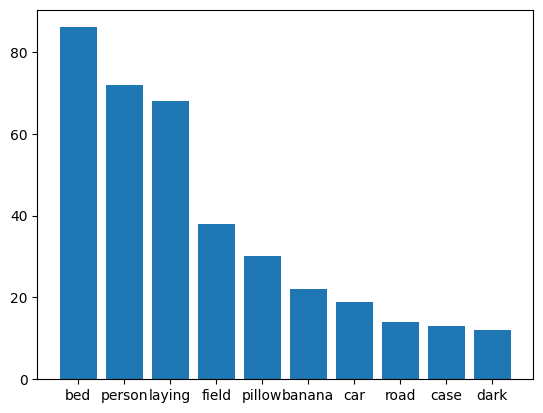

In [49]:
words_coll_irf = [x for x in " ".join(all_blip_irf_text).split(" ") if x not in wc.stopwords]
mc = Counter(words_coll_irf).most_common(10)
plt.bar(*zip(*mc))

In [50]:
samples = [x for x in result_list if "sn9279_" in x["path"]]

In [51]:
len(samples)

128

In [52]:
# sort by name
samples = sorted(samples, key=lambda x: int(x["path"].split("/")[-1].split("_")[1].split(".")[0]))

In [53]:
for item in samples:
    print(item["path"].split("/")[-1])
    print(item["blip"]["pred"])

sn9279_1.bmp
a black and white photo of a banana on a table
sn9279_2.bmp
a black and white photo of a person in a field with a kite
sn9279_3.bmp
a black and white photo of a person in a field with a kite
sn9279_4.bmp
a black and white photo of a person holding a tennis racket
sn9279_5.bmp
a black and white photo of a person with a surfboard
sn9279_6.bmp
a black and white photo of a plane flying over a field
sn9279_7.bmp
a black and white photo of a person riding a skateboard
sn9279_8.bmp
a black and white photo of a banana with a long stem
sn9279_9.bmp
a black and white photo of a banana with a long stem
sn9279_10.bmp
a black and white photo of a banana with a banana peel
sn9279_11.bmp
a black and white photo of a banana with a blurry background
sn9279_12.bmp
a black and white photo of a long curved bone with a thin bone
sn9279_13.bmp
a black and white photo of a banana with a long stem
sn9279_14.bmp
a black and white photo of a banana in a dark room
sn9279_15.bmp
a black and white pho

In [151]:
from nltk.translate.bleu_score import sentence_bleu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [156]:
candidate = 'a person in a field with a kite'.split()
reference =[
    "a banana on a table".split(),
    "a person in a field with a kite".split(),
]
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.0


In [164]:
samples[2]["clip_base_embed"] @ samples[3]["clip_base_embed"].T

tensor(296.1071, grad_fn=<DotBackward0>)

In [54]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

/home/xiaolhu/.conda/envs/wsss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
result_list = [
    {
        **x,
        "sort_num": (x["path"].split("/")[-1].split("_")[0], int(x["path"].split("/")[-1].split("_")[1].split(".")[0])),
    } for x in result_list
]
sorted_result_list = sorted(result_list, key=lambda x: x["sort_num"])

In [57]:
sorted_result_list[:2]

[{'path': '../datasets/RESC/train/original_images/sn10072_1.bmp',
  'blip': {'pred': 'a black and white photo of a banana with a long stem',
   'norm_pred': 'a banana with a long stem',
   'clip_base_embed': tensor([ 1.4445, -1.4345,  0.3101,  4.8063, -1.7130, -0.9864, -1.0506,  0.3446,
           -0.3325,  0.5713,  0.4525,  0.2186,  0.4295,  1.0842,  2.0634,  0.2122,
           -1.8994, -1.2535, -1.6060,  0.5640, -0.6721,  0.8384,  0.4292,  0.7097,
           -0.8367, -1.4162, -0.0154,  0.1188, -1.1225,  1.2572,  1.7507, -0.5034,
           -0.0511,  1.2855, -0.4841, -1.7248, -0.2354,  0.3543, -1.1367,  2.3403,
            0.3675,  0.5976, -1.3045,  3.1817,  0.3251,  0.9468, -0.3037,  0.6791,
            1.2323, -1.1962, -1.1985, -0.1091,  2.2193,  0.8711,  0.2768, -0.2904,
           -1.0164,  0.6995,  0.6504, -0.4791, -0.5510,  0.5479,  0.3988,  0.2760,
            0.1804,  0.1187,  0.3743,  0.1804, -0.2834, -0.5527, -1.4574,  0.0358,
            0.5447,  0.9213,  0.1284,  1.0693,  

In [58]:
unique_patient_ids = set([x["sort_num"][0] for x in sorted_result_list])

In [59]:
len(unique_patient_ids)

85

In [60]:
sorted_result_list[0]["blip"].keys()

dict_keys(['pred', 'norm_pred', 'clip_base_embed', 'norm_clip_base_embed', 'clip_large_embed', 'norm_clip_large_embed', 'minilm_embed'])

In [84]:
sorted_result_list[0]["vit"].keys()

dict_keys(['pred', 'clip_base_embed', 'clip_large_embed', 'minilm_embed'])

In [61]:
cosine_scores = util.pytorch_cos_sim(sorted_result_list[1]["blip"]["clip_base_embed"], sorted_result_list[2]["blip"]["clip_base_embed"])
cosine_scores

tensor([[0.8548]], grad_fn=<MmBackward0>)

In [87]:
all_window_collections = {}
window_3_cosine = []

for window_size in range(3, 66, 2):
    all_window_collections[window_size] = []
    for patient_id in unique_patient_ids:
        test_col = []
        patient_samples = [x["vit"] for x in sorted_result_list if x["sort_num"][0] == patient_id]
        # calcaluate cosin similarity with window size of 3, 5, 7, ... 65, . score between neighbor against the center one, and average
        for i in range(window_size//2, len(patient_samples)-window_size//2):
            candidates = [x["minilm_embed"] for x in patient_samples[i-window_size//2:i+window_size//2+1]]
            # drop the middle position, as it is the same as the center one
            candidates.pop(window_size//2)
            candidates = torch.stack(candidates)
            cosine_scores = util.pytorch_cos_sim(candidates, patient_samples[i]["minilm_embed"])
            avg_cosine = cosine_scores.sum().item() / (window_size-1)
            test_col.append(avg_cosine)
            all_window_collections[window_size].append(avg_cosine)
# average the cosine similarity for each window size
all_window_collections_median = {x: np.median(all_window_collections[x]) for x in all_window_collections}
all_window_collections = {x: sum(all_window_collections[x]) / len(all_window_collections[x]) for x in all_window_collections}


(0.5, 0.7)

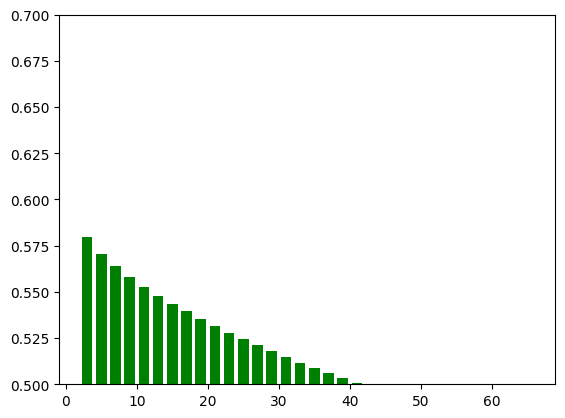

In [88]:
plt.bar(all_window_collections.keys(), all_window_collections.values(), 1.5, color='g')
plt.ylim(0.5,0.7)

(0.5, 0.7)

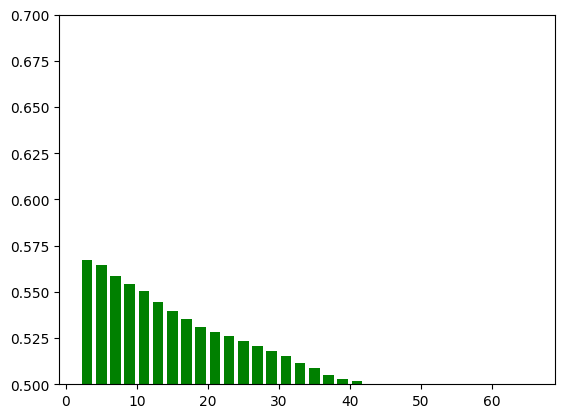

In [89]:
# plot from 0.6 to 1
plt.bar(all_window_collections_median.keys(), all_window_collections_median.values(), 1.5, color='g')
plt.ylim(0.5,0.7)


In [68]:
all_window_collections_median[3], all_window_collections_median[5], all_window_collections_median[7], all_window_collections_median[65]

(0.64410799741745, 0.6239990293979645, 0.6150566140810649, 0.5142178237438202)

In [64]:
all_window_collections[3], all_window_collections[5], all_window_collections[7], all_window_collections[65]

(0.7556262730188619, 0.7516265122075009, 0.7480885672630582, 0.67882306683699)

In [261]:
sum(window_3_cosine) / len(window_3_cosine), sum(window_5_cosine) / len(window_5_cosine), sum(window_7_cosine) / len(window_7_cosine), sum(window_65_cosine) / len(window_65_cosine)

(0.7556262730188619, 0.7516265122075009, 0.7480885672630576, 0.67882306683699)

(0.5, 0.8)

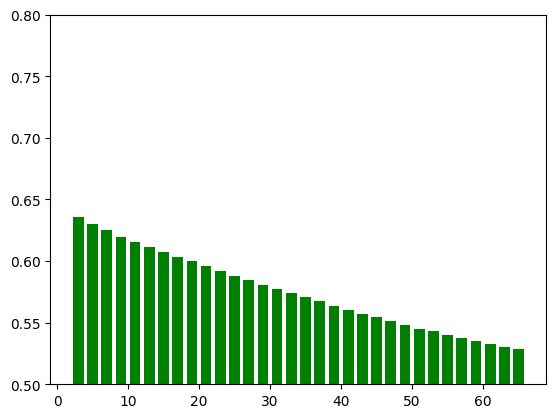

In [50]:
# vit captioning
plt.bar(all_window_collections.keys(), all_window_collections.values(), 1.5, color='g')
plt.ylim(0.5,0.8)

(0.5, 0.8)

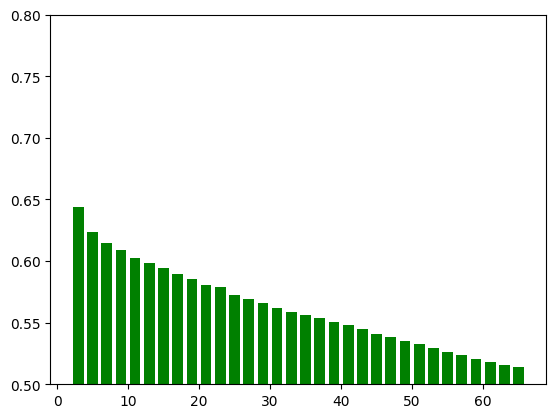

In [49]:
plt.bar(all_window_collections_median.keys(), all_window_collections_median.values(), 1.5, color='g')
plt.ylim(0.5,0.8)